In [47]:
import os
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
from matplotlib.lines import Line2D
import math

from pcg_stein.registry import PRECON_REGISTRY
from pcg_stein.util import make_main_plot

import seaborn as sns


import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

os.getcwd()

'/home/matth/dev/python/jax/pcg_stein/experiments/fig6_experiment'

#### Load Data and Define Metrics

In [2]:
cg_results = pd.read_csv('results/fig6_cg.csv') # CG results
pcg_results = pd.read_csv('results/fig6_pcg.csv') # PCG results
mc_results = pd.read_csv('results/fig6_mc.csv') # Monte-Carlo results

In [48]:
import yaml

with open('experiment.yaml') as f:
    cfg = yaml.safe_load(f)


In [ ]:
def make_quad_plot(cg_results, pcg_results, mc_results, dim=0, precon="RandomisedEVD", title=None):
    cg_dim = cg_results[cg_results["dim"] == dim]
    pcg_dim = pcg_results[pcg_results["dim"] == dim]
    mc_dim = mc_results[mc_results["dim"] == dim]

    gs_ = mc_dim[mc_dim["gold_standard"] == True]["value"].item()

    # Reference Monte-Carlo estimates
    mc_compare = mc_dim[mc_dim["gold_standard"] != True]
    mc_mean = mc_compare["value"].mean().item()
    mc_se = mc_compare["value"].sem().item()

    pcg_dim = pcg_dim[pcg_dim["precon"] == precon]

    stats_pcg = (
        pcg_dim
        .groupby(["precon", "lengthscale", "nugget", "quad_index"])["value"]
        .agg(mean="mean", sem="sem")
        .reset_index()
    )

    stats_cg = (
        pcg_dim
        .groupby(["lengthscale","quad_index"])["value"]
        .agg(mean="mean", sem="sem")
        .reset_index()
    )

    for precon, g_precon in stats_pcg.groupby("precon"):
        lengths  = sorted(g_precon["lengthscale"].unique())
        nuggets  = sorted(g_precon["nugget"].unique())
        n_rows   = len(lengths)
        n_cols   = len(nuggets)

        fig, axes = plt.subplots(
            n_rows, n_cols,
            figsize=(2 * n_cols, 2 * n_rows),
            sharex='col', sharey='row',
            squeeze=True,
            gridspec_kw=dict(wspace=0.05,
                             hspace=0.05)  
        )


        # fill the grid of sub-plots
        for i, ls in enumerate(lengths):
            for j, ng in enumerate(nuggets):
                ax   = axes[i][j]
                sub  = (g_precon
                        .query("lengthscale == @ls and nugget == @ng")
                        .sort_values("quad_index"))

                sub_cg = (stats_cg
                        .query("lengthscale == @ls")
                        .sort_values("quad_index"))

                x_pcg  = sub["quad_index"].to_numpy()
                y_pcg  = sub["mean"].to_numpy()
                se_pcg = sub["sem"].to_numpy()

                x_cg  = sub_cg["quad_index"].to_numpy()
                y_cg  = sub_cg["mean"].to_numpy()
                se_cg = sub_cg["sem"].to_numpy()

                # True only for the very first axis
                first_axis = (i == 0 and j == 0)

                # ----- PCG ---------------------------------------------------------
                colour = ax._get_lines.get_next_color()
                ax.fill_between(x_pcg, y_pcg - se_pcg, y_pcg + se_pcg,
                                color=colour, alpha=0.25)
                ax.plot(x_pcg, y_pcg,
                        color=colour, lw=2,
                        label="PCG" if first_axis else "_nolegend_") 

                # ----- CG ----------------------------------------------------------
                colour = ax._get_lines.get_next_color()
                ax.fill_between(x_cg,  y_cg - se_cg,  y_cg + se_cg,
                                color=colour, alpha=0.25)
                ax.plot(x_cg, y_cg,
                        color=colour, lw=2,
                        label="CG" if first_axis else "_nolegend_")   

                # ----- MC ----------------------------------------------------------
                colour = ax._get_lines.get_next_color()
                ax.plot([x_cg[0], x_cg[-1]], [mc_mean, mc_mean], color=colour, 
                               lw=2, label="Monte Carlo" if first_axis else "_nolegend_")
                ax.fill_between([x_cg[0], x_cg[-1]], [mc_mean - mc_se, mc_mean - mc_se],  [mc_mean + mc_se, mc_mean + mc_se],
                                color=colour, alpha=0.25)


                # horizontal reference line (never goes in legend)
                
                ax.axhline(gs_, color="black", ls="--", lw=1, zorder=0, label="Reference" if first_axis else "_nolegend_")
                ax.margins(y=0.05) 
                # ─────── cosmetic tweaks ──────────────────────────
                if i == n_rows - 1:                   # bottom row → x-labels
                    ax.set_xlabel("$m$", fontsize=12) # iteration m of CG
                # else:
                #     ax.set_xticklabels([])
                    # ax.set_xticks([])

                if j == 0:                            # left column → y-label = ℓ
                    ax.set_ylabel(fr"$\ln \ell = {math.log(ls):.0f}$", fontsize=12)
                # else:
                #     ax.set_yticklabels([])  # keep ticks but no numbers
                    # ax.set_yticks([])
                #     ax.set_ylabel("")

                if i == 0:                            # top row → title = η
                    ax.set_title(fr"$\ln \eta = {math.log(ng):.0f}$", fontsize=12)


        # global title + layout tweaks
        if title is not None:
            fig.subplots_adjust(top=0.88)
            fig.suptitle(r"\textbf{" + title + "}", fontsize=14)
            line = Line2D(
                [0.06, 0.94],
                [0.96, 0.96],
                transform=fig.transFigure,
                color="black",
                linewidth=0.3,
            )
            fig.add_artist(line)


        # Pull the two handles/labels from the first axis
        handles, labels = axes[0][0].get_legend_handles_labels()

        fig.legend(handles, labels,
                loc="center right",          # pick a corner you like
                bbox_to_anchor=(1.05, 0.5),  # (x, y) in figure coords
                frameon=False, fontsize=12)

        fig.subplots_adjust(right=0.9, top=0.92, bottom=0.1)

        return fig, axes

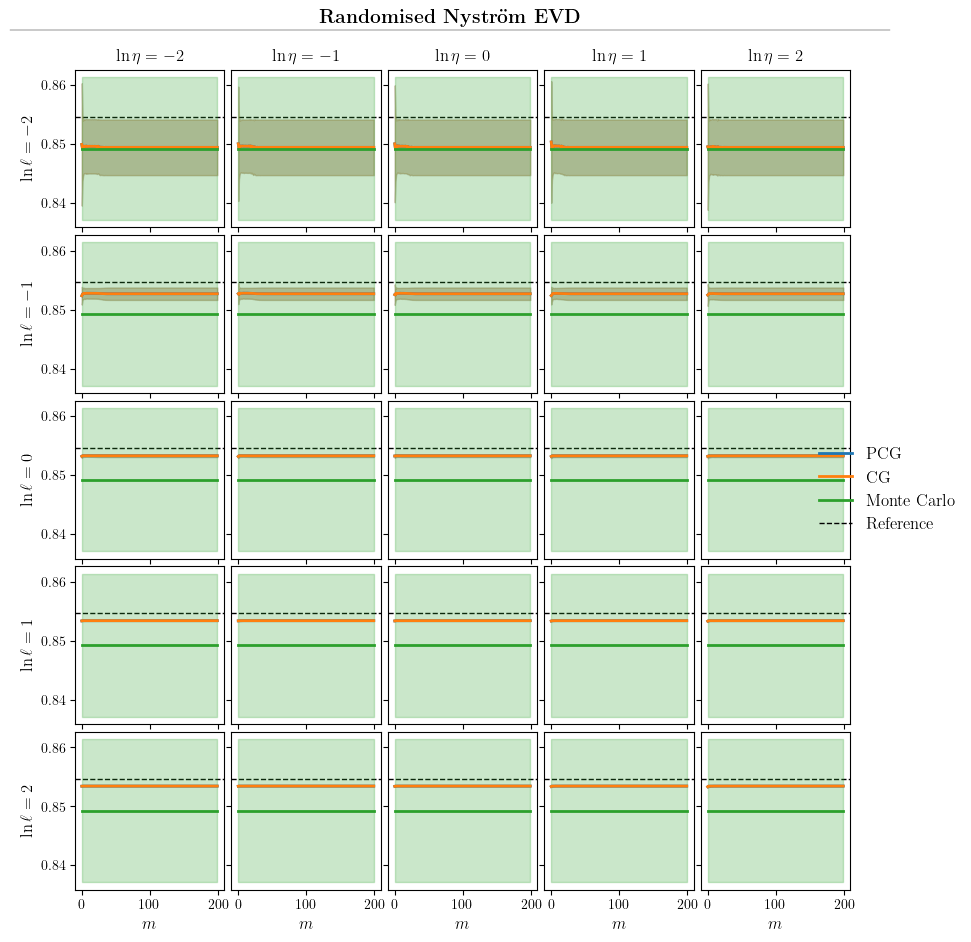

In [113]:
fig, _ = make_quad_plot(cg_results, pcg_results, mc_results, title=PRECON_REGISTRY["RandomisedEVD"].display_name)

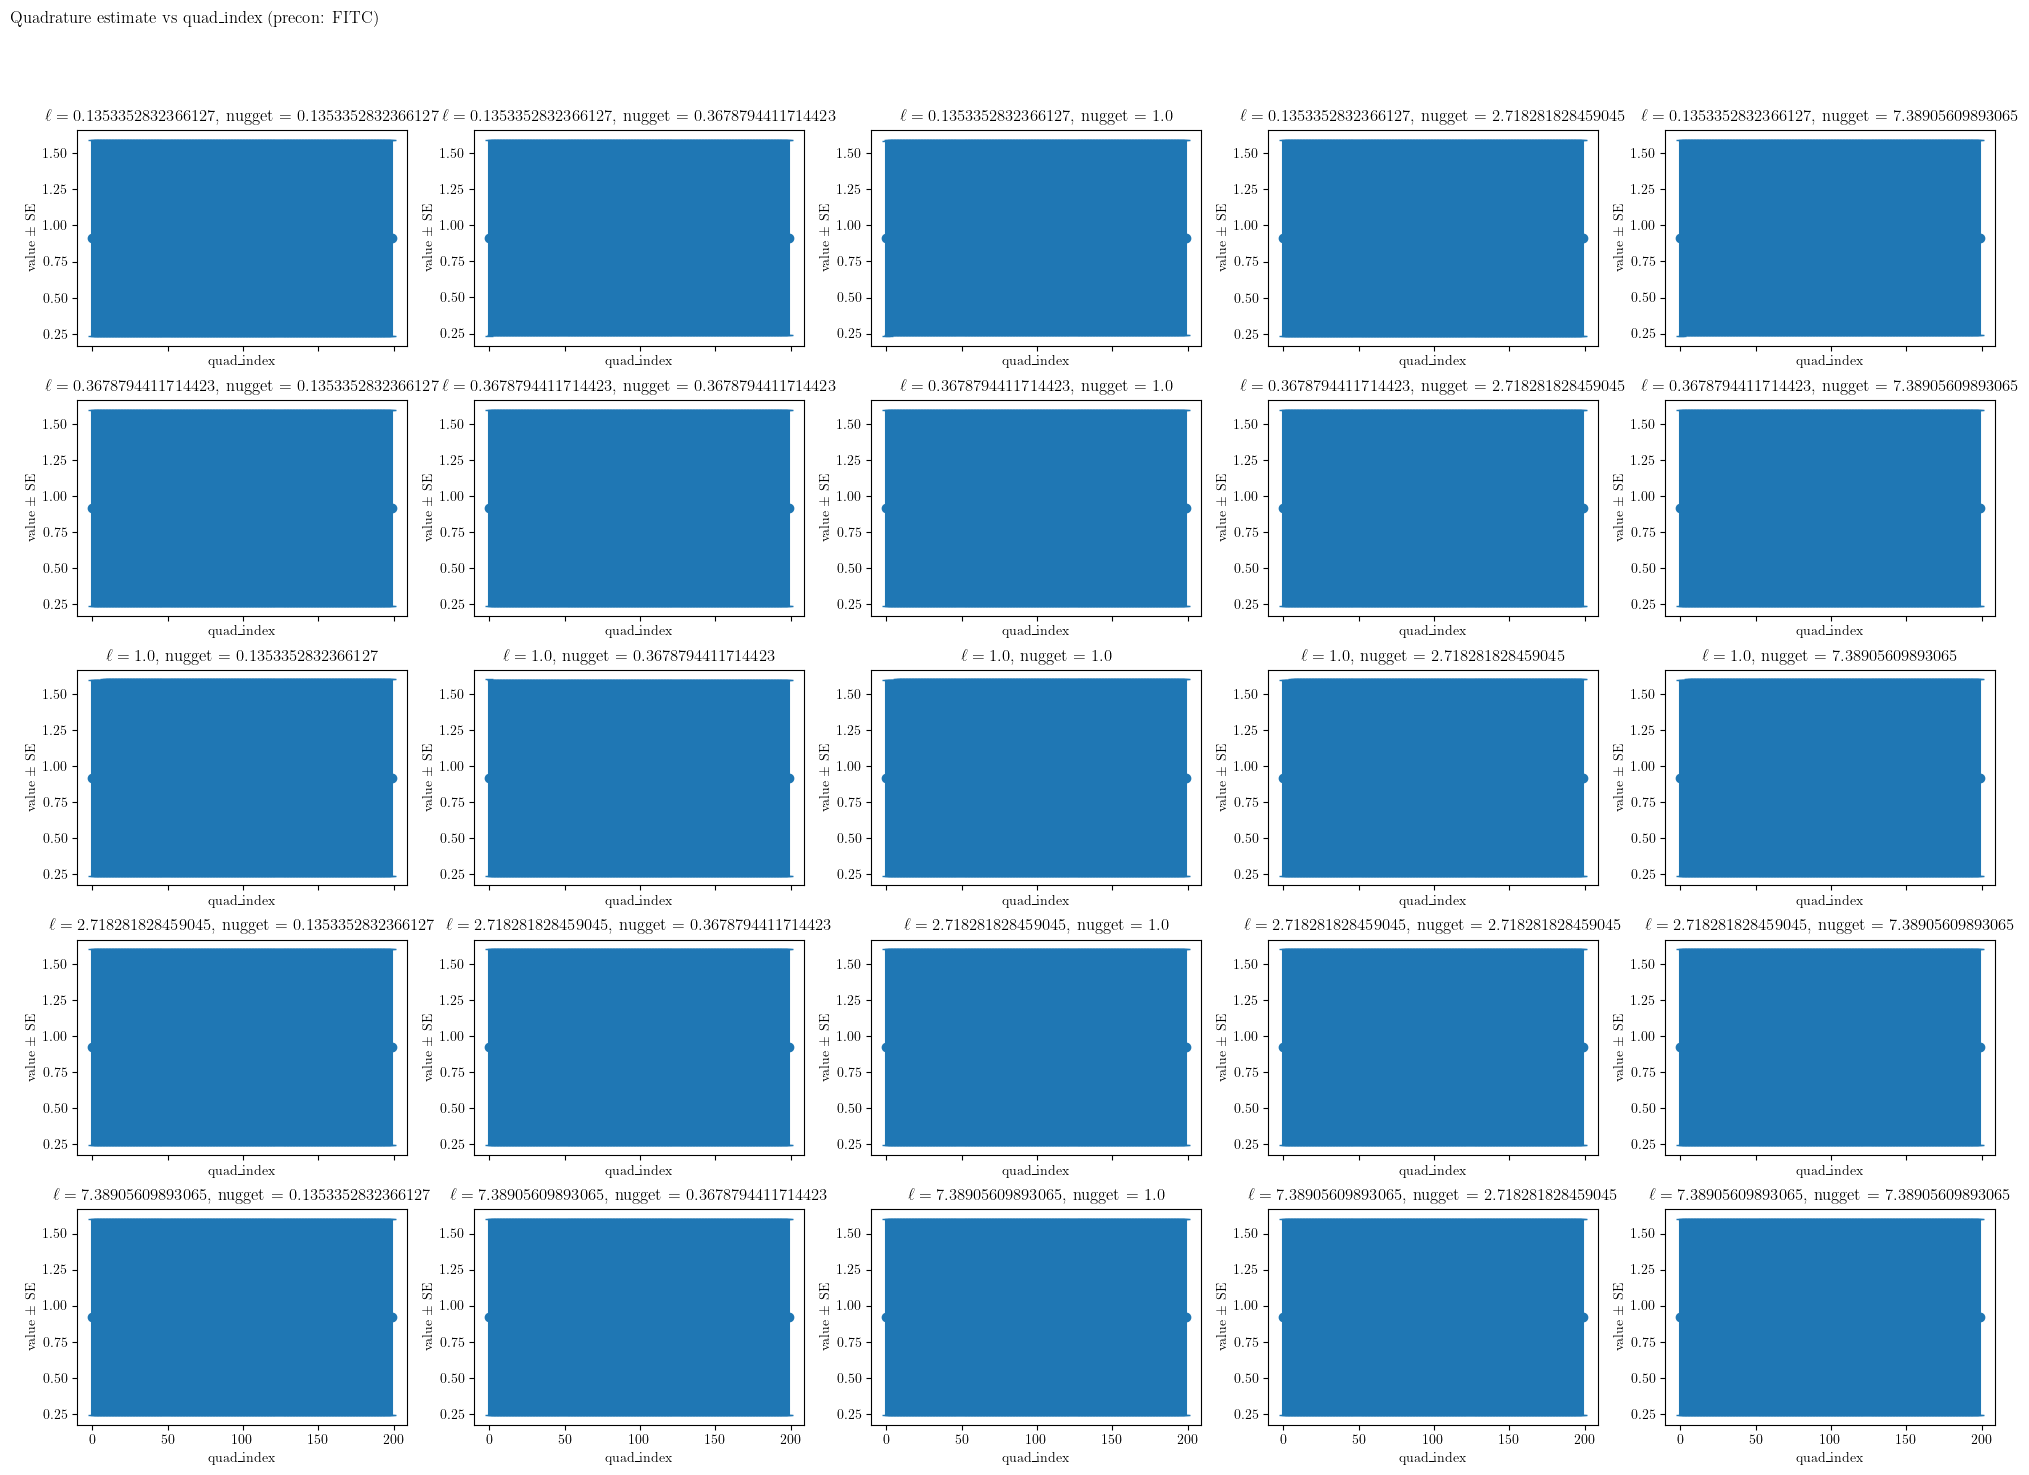

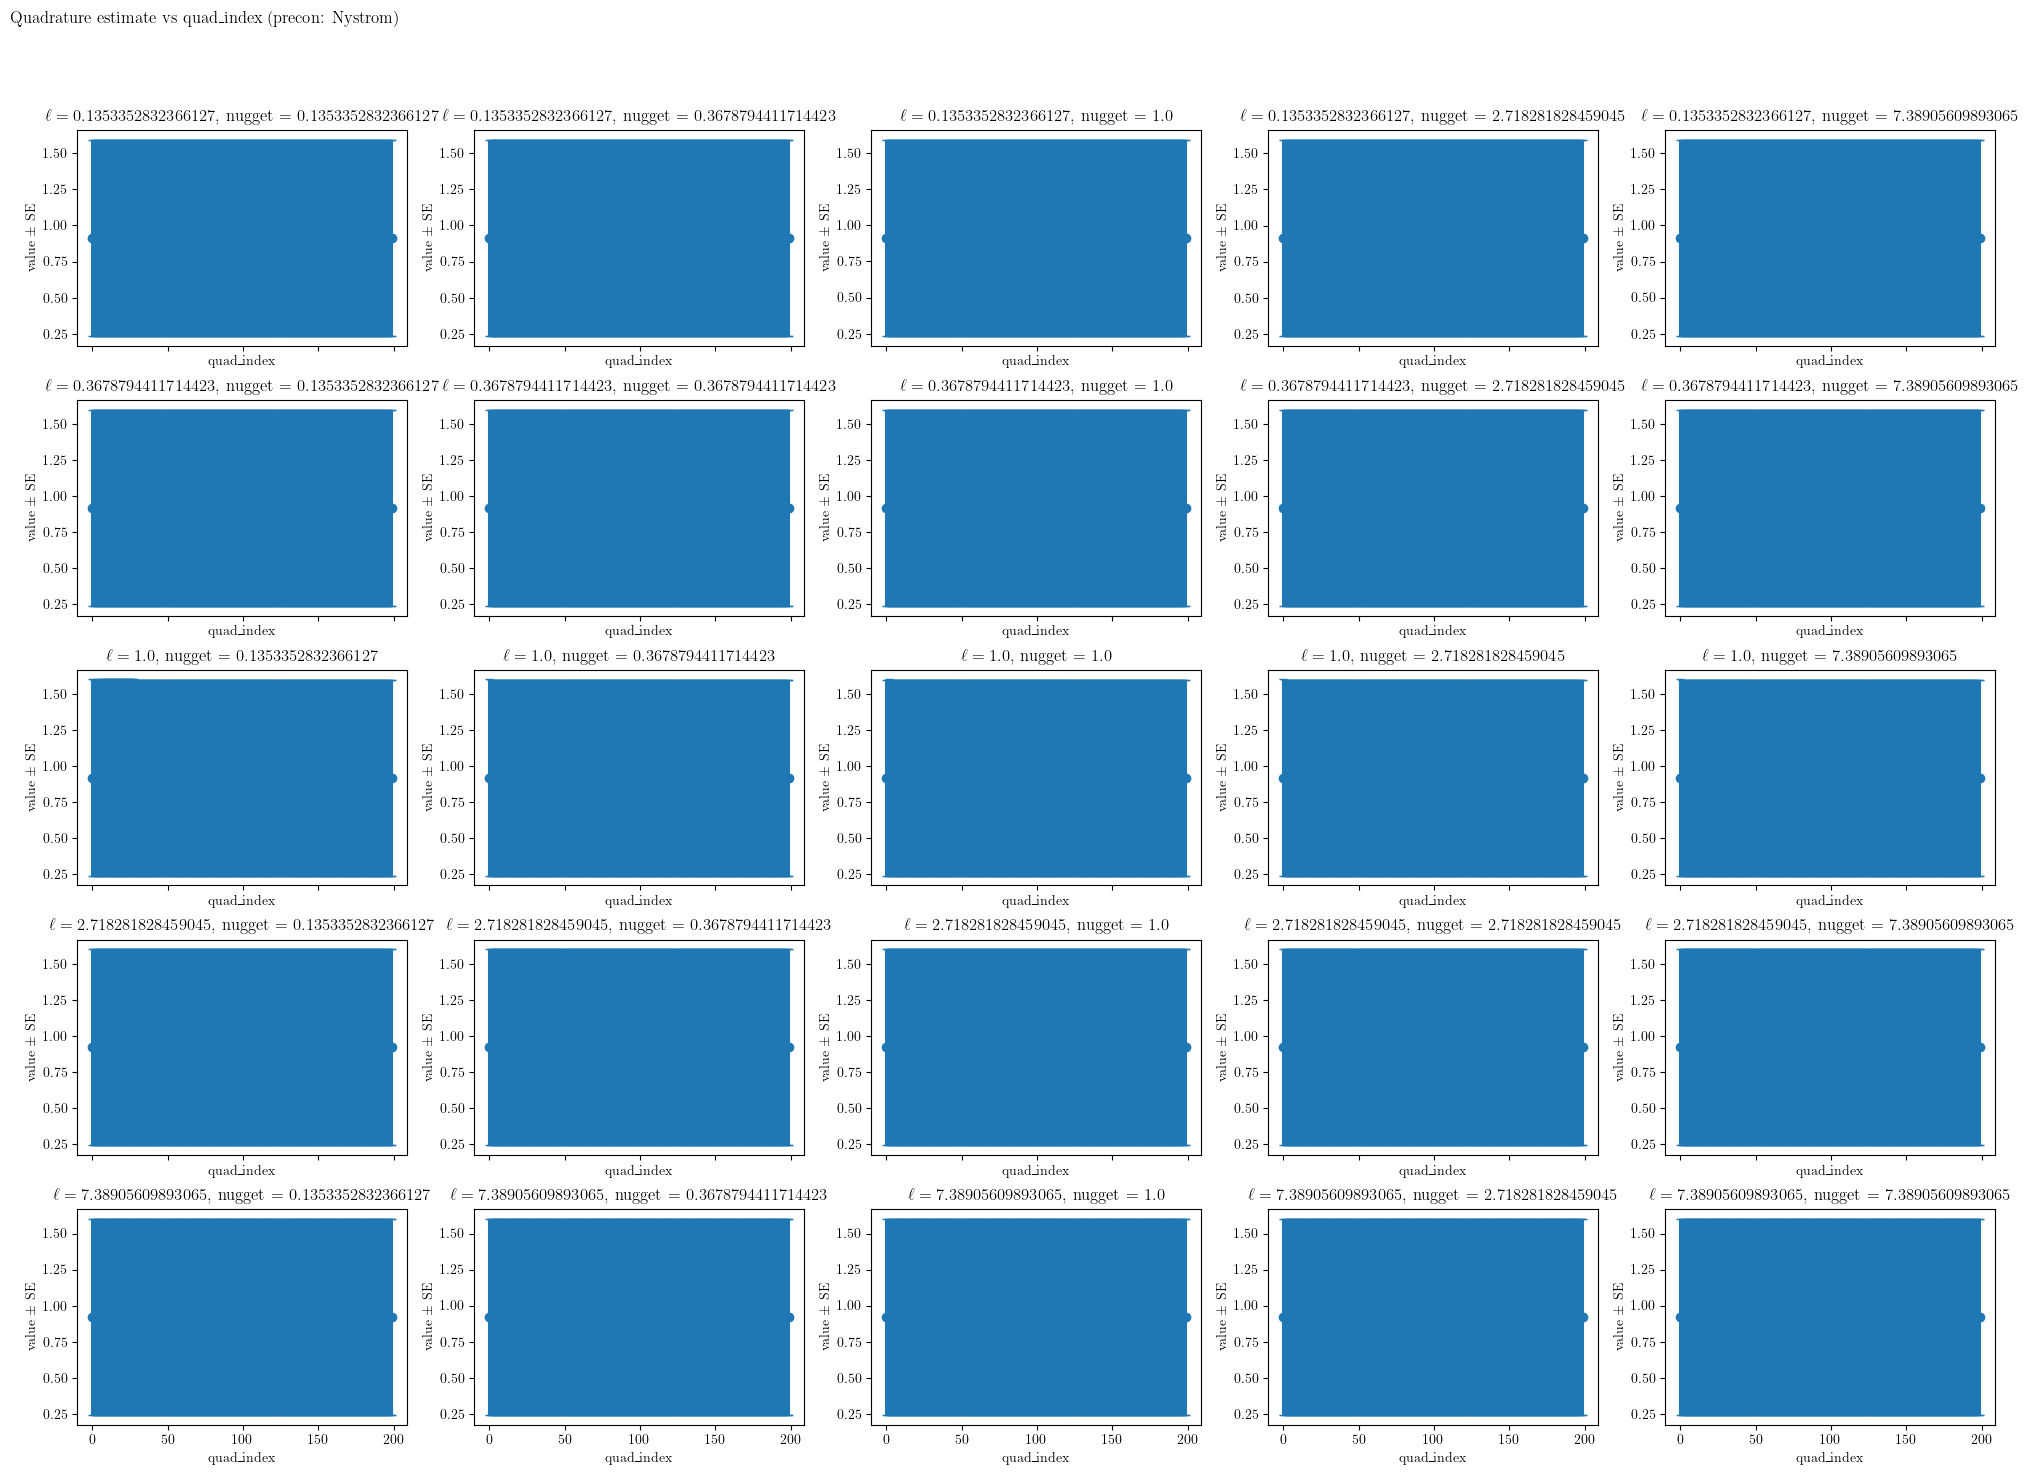

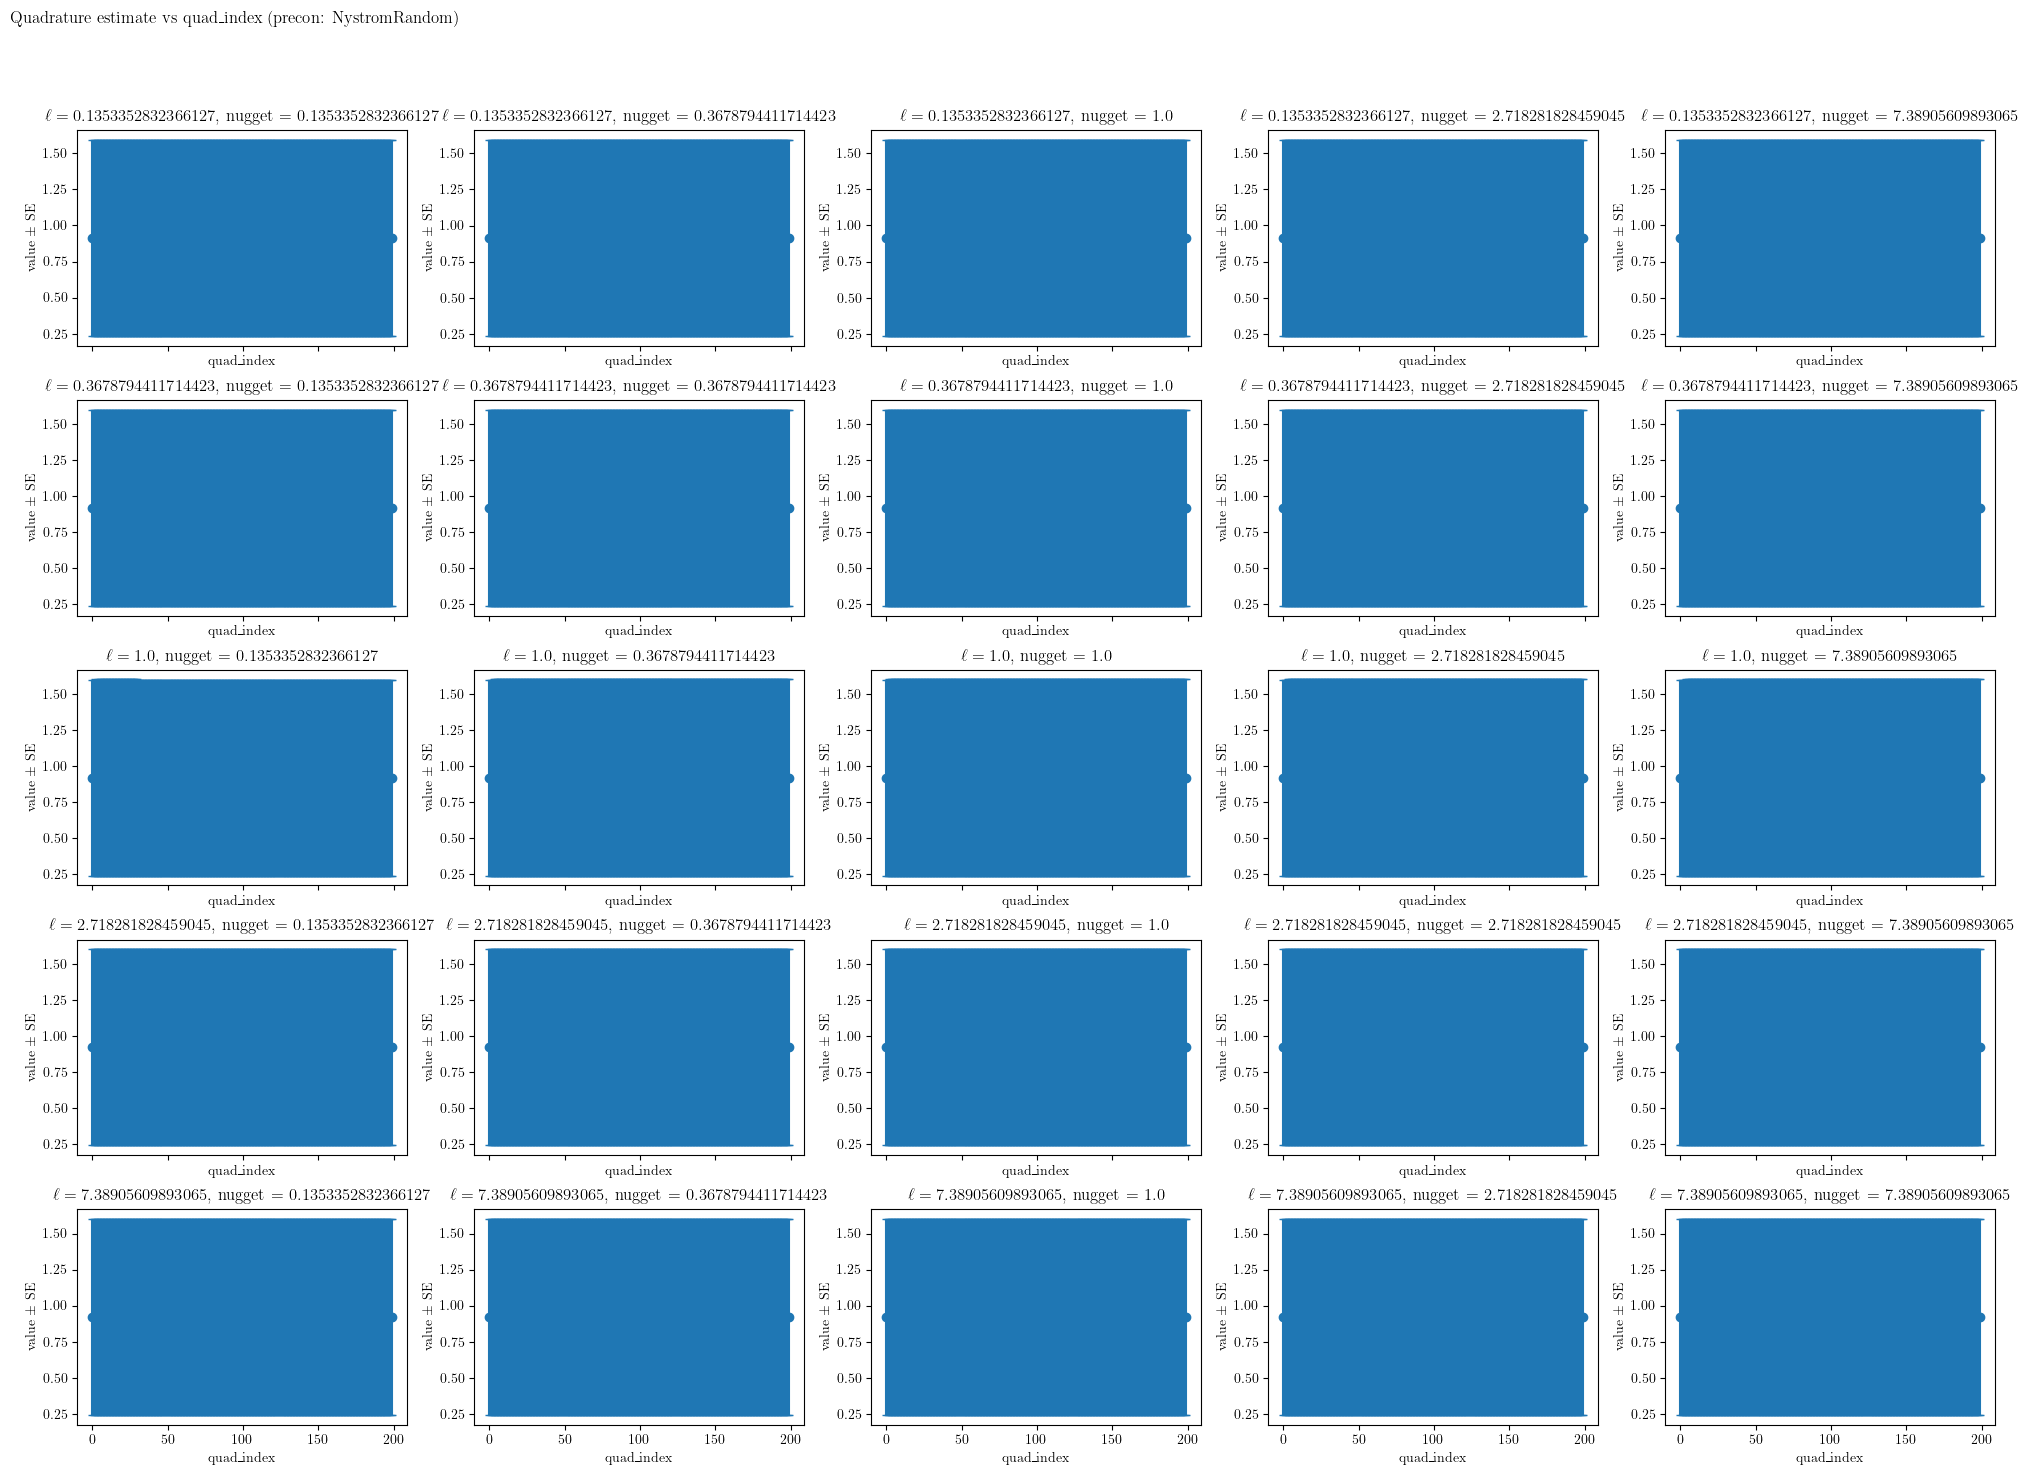

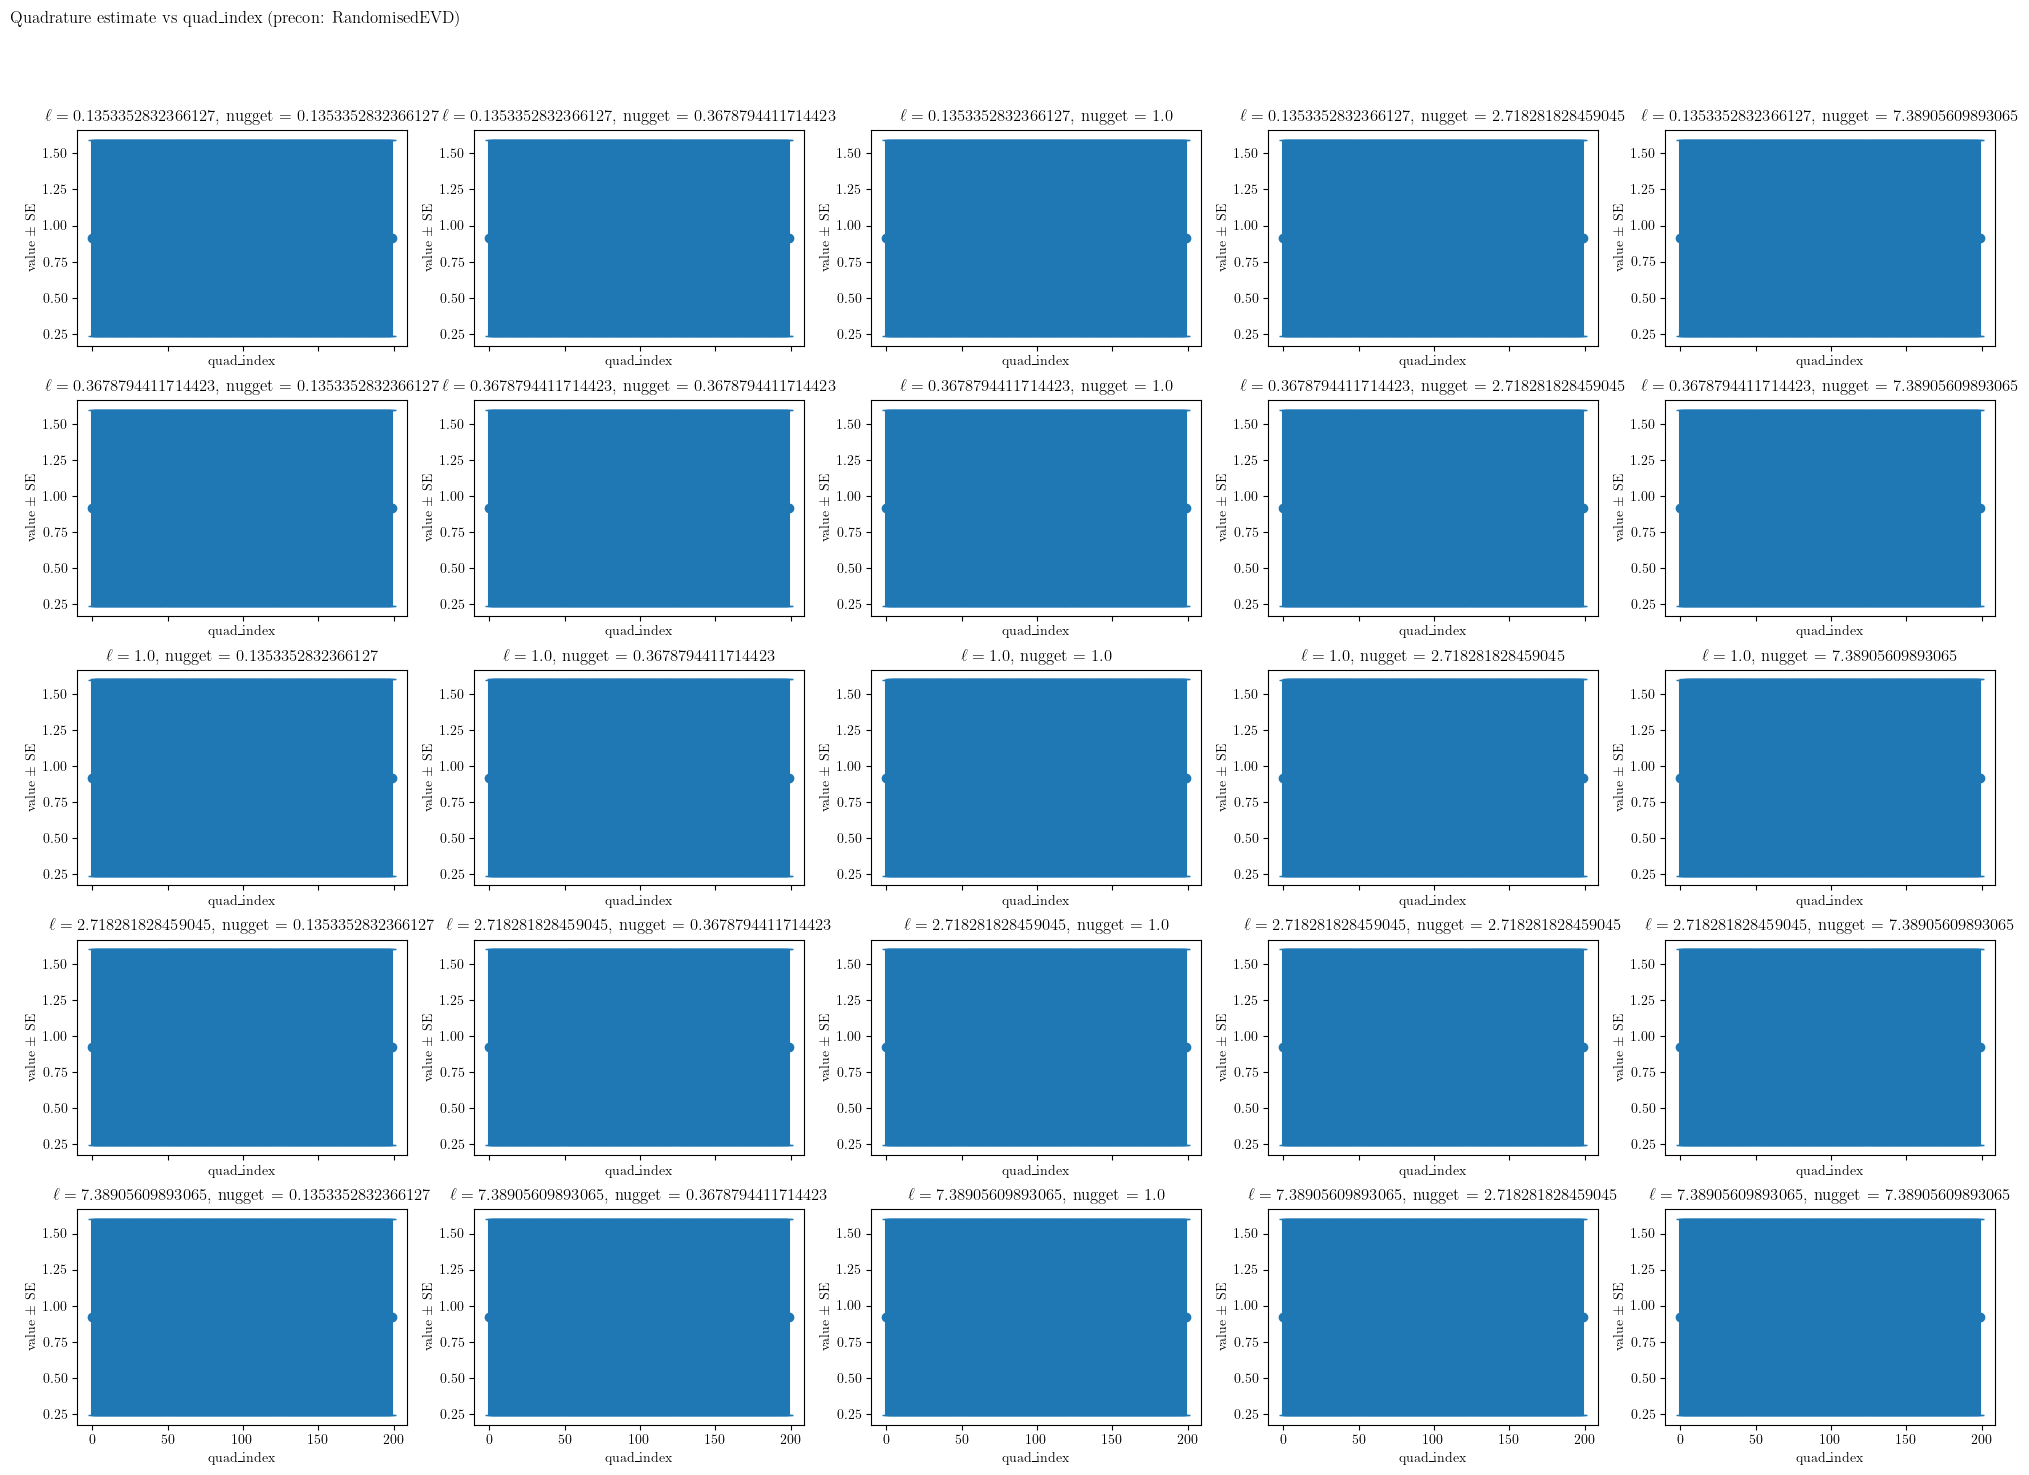

In [ ]:
# make sure quad_index is integer so it sorts nicely
pcg_results["quad_index"] = pcg_results["quad_index"].astype(int)

# ---------------------------------------------
# 2.  pre-compute mean and standard error
# ---------------------------------------------
stats = (
    pcg_results
    .groupby(["precon", "lengthscale", "nugget", "quad_index"])["value"]
    .agg(mean="mean", sem="sem")
    .reset_index()
)

# ---------------------------------------------
# 3.  one figure per pre-conditioner
# ---------------------------------------------
for precon, g_precon in stats.groupby("precon"):
    lengths  = sorted(g_precon["lengthscale"].unique())
    nuggets  = sorted(g_precon["nugget"].unique())
    n_rows   = len(lengths)
    n_cols   = len(nuggets)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 3 * n_rows),
        sharex=True, sharey=False,
        squeeze=True,
    )

    # -----------------------------------------
    # 4.  fill the grid of sub-plots
    # -----------------------------------------
    for i, ls in enumerate(lengths):
        for j, ng in enumerate(nuggets):
            ax   = axes[i][j]
            sub  = (
                g_precon
                .query("lengthscale == @ls and nugget == @ng")
                .sort_values("quad_index")
            )
            ax.errorbar(
                sub["quad_index"],
                sub["mean"],
                yerr=sub["sem"],
                linestyle="-",
                marker="o",
                capsize=3,
            )
            ax.set_title(fr"$\ell = {ls}$, nugget = {ng}")
            ax.set_xlabel("quad_index")
            ax.set_ylabel("value ± SE")

    # -----------------------------------------
    # 5.  global title + layout tweaks
    # -----------------------------------------
    fig.suptitle(
        f"Quadrature estimate vs quad_index  (precon: {precon})",
        x=0.0, ha="left",
    )
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)   # leave space for the suptitle
    plt.show()

### Create Figures and Save

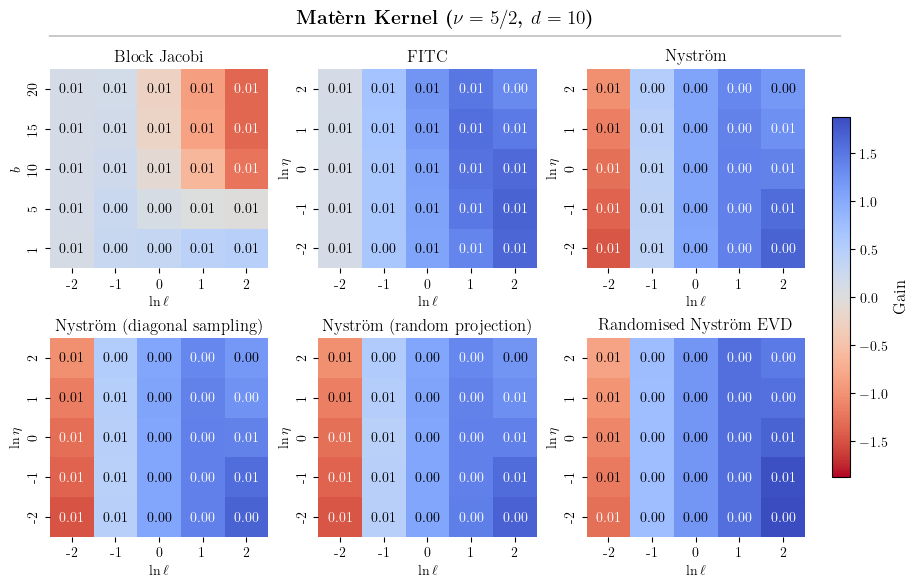

In [ ]:
fig5, _ = make_main_plot(results, labels, metric="gain", cbar_label="Gain", title=r"Mat\`{e}rn Kernel ($\nu = 5/2$, $d=10$)")

fig5.savefig(
    "figs/fig5.pdf",  
    format="pdf",     
    bbox_inches="tight",  
    pad_inches=0          
)

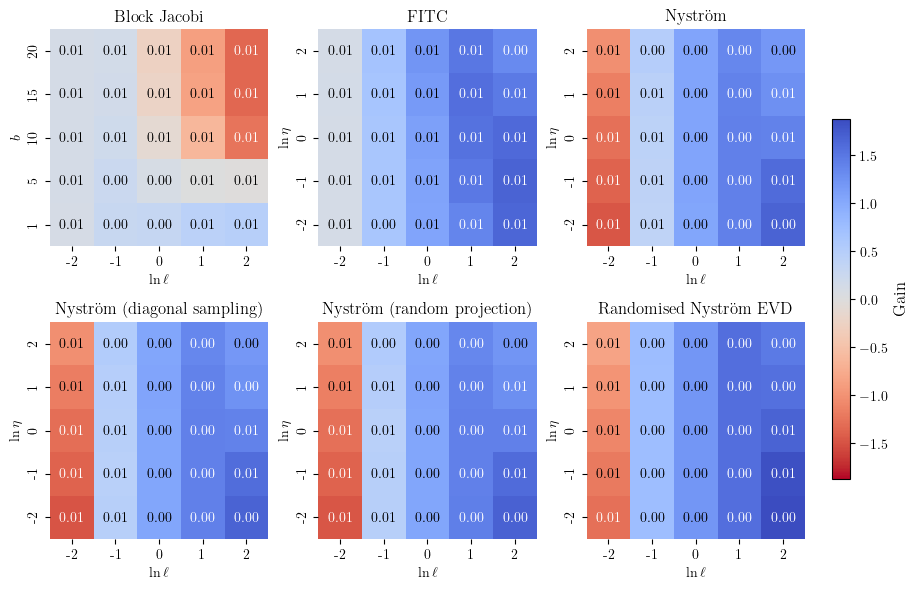

In [ ]:
fig5_notitle, _ = make_main_plot(results, labels, metric="gain", cbar_label="Gain")

fig5_notitle.savefig(
    "figs/fig5_notitle.pdf",  
    format="pdf",     
    bbox_inches="tight",  
    pad_inches=0          
)

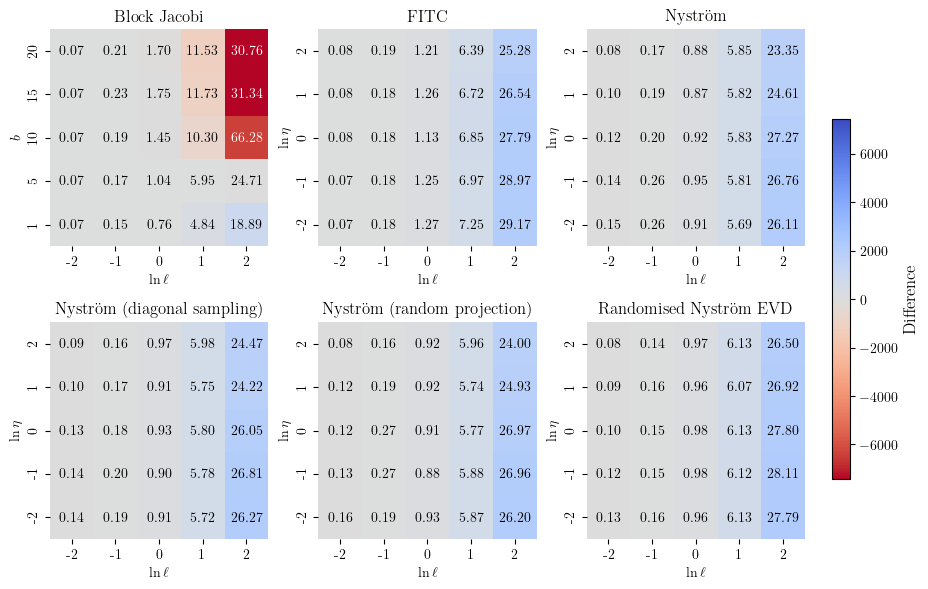

In [7]:
fig5_diff, _ = make_main_plot(results, labels, metric="diff", cbar_label="Difference")

fig5_diff.savefig(
    "figs/fig5_diff.pdf",    
    format="pdf",         
    bbox_inches="tight", 
    pad_inches=0          
)